# Monge, Bregman and Occam: Interpretable Optimal Transport in High-Dimensions with Feature-Sparse Maps 

## Abstract

In this tutorial, we cover how to solve high dimensional optimal transport problems with feature-sparse maps based on the paper [Monge, Bregman and Occam: Interpretable Optimal Transport in High-Dimensions with Feature-Sparse Maps](https://proceedings.mlr.press/v202/cuturi23a.html).

## Introduction

#### Optimal Transport in Machine Learning
In the realm of machine learning, Optimal Transport serves as a fundamental tool for transferring observations from a source to a target probability measure, finding applications in domain adaptation, generative model training, and dataset realignment across various disciplines. The practical efficacy and guiding theoretical principles of OT computational approaches are underscored.

#### Challenges and Solutions in High-Dimensional Transport
 However, challenges arise when dealing with high-dimensional spaces, where the conventional choice of cost function, often based on the Euclidean distance, loses significance due to the curse of dimensionality. While dimensionality reduction techniques like PCA or VAE are commonly employed, they may yield transport maps that are difficult to interpret in the original space. To address this, the [paper](https://proceedings.mlr.press/v202/cuturi23a.html) introduces an innovative approach utilizing the sparsity toolbox to construct Optimal Transport maps that are both simpler and adaptive to input. This method involves leveraging generalized entropic maps and elastic-type regularizers to produce sparse displacements, allowing for effective interpretation and application in extremely high-dimensional datasets, as exemplified in the analysis of single-cell transcription data.

## Imports 

In [1]:
import torchvision.datasets as datasets
import numpy as np
import os
from functools import partial
from jax import jit
import jax
import jax.numpy as jnp
import torchvision
import jax.random as random
import matplotlib.pyplot as plt
import ott
import pandas as pd

/home/tordjx/miniconda3/envs/rapidsjpp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Mathematical framework

In the following, we consider a translation-invariant cost function $c(x, y) := h(x − y)$, where $h : \mathbb{R}^d \to \mathbb{R}$. Especially, we focus on elastic-type cost functions which are strongly convex and can be expressed as a combination of a quadratic term and a sparsity-inducing function $\tau$.

$$h(z) := \frac{1}{2}   \| z \|  ^2 + \tau (z) $$

To recall, the Monge problem consists of finding, among all maps $T : \mathbb{R}^d \to \mathbb{R}^d$ the one which minimizes the average lenght of its displacements

$$T^* := \arg \inf_{T\#\mu = \nu} \int_{\mathbb{R}^d} h(x - T(x)) d \mu$$

We can compute the Monge map under elastic-type costs thanks to:

**Proposition 1.** For For elastic-type costs $h$ and $x \in \Omega_{\hat{\nu}_m}(τ )$ one has:

$$ T_{h, \epsilon} (x) = x - \text{prox}_{\tau} ( x - \sum_{j=1}^m p^j (x) (y^j - \nabla \tau (x - y^j)))$$

In our framework, we explore 2 different cost functions $\tau$.

**Norm $\ell_1$** : $$ \tau (z) = \gamma \| z \|_1 $$ where $\text{prox}_{\gamma \ell_1} (z) = \text{ST}(z, \gamma) = (1 - \frac{\gamma}{\left| z \right|})_+ \circ z $  is  the *soft-thresholding operator*. 

We also have $ \nabla h(z) = z + \gamma \text{sign}(z) $ for $z$ with non zero coordinate. 

Thus, according to **Propostion 1.** we find that the Monge map is: $$ T_{\gamma \ell_1,\epsilon}(x) = x - \text{ST}_{\gamma} ( x - \sum_{j=1}^m p^j (x) (y^j + \gamma \text{sign} (x - y^j))) $$

The soft-thresholding operator operates to induce sparse displacements locally on specific coordinates. Additionally, it shrinks values; when a coordinate exceeds $\gamma$, it is decreased by $\gamma$. However, this effect may result in a "shortening" of displacement lengths within the entropic maps.

**Soft Thresholding with Vanishing Shrinkage (STVS)**

To address the issue of *shortening* in the $\ell_1$ norm, we employ the STVS: 

$$ \tau (z) = \gamma^2 \mathbb{1}_d^T (\sigma(z) + \frac{1}{2} - \frac{1}{2} \exp^{-2 \sigma (z)} ) \quad \text{with} \quad \sigma (z) := \text{asinh}(\frac{z}{2 \gamma})$$ 

where $\text{prox}_{\tau_{stvs}} = ( 1 - \frac{\gamma^2}{\left| z \right| ^2})_+ \circ z$.

Additionally, the Hessian of $\tau_{stvs}$ is a diagonal matrix with values $\frac{1}{2} \left| z \right| / \sqrt{z^2 + \gamma^2} - \frac{1}{2}$.

**The goal of this tutorial is to approximate $T^*$ by $T_{h,\epsilon}$.**

Computing the map for a single point entails calculating the gradient of the entropic potential followed by a single proximal operator evaluation. This process is streamlined by introducing a class of regularized translation-invariant cost functions, called RegTICost, which defines both the regularizer $\tau$ for Sinkhorn and its proximal operator for map evaluation. This entire procedure can be seamlessly executed using the OTT-JAX library.

In [2]:
from typing import Any
from jax.numpy import ndarray
from ott.geometry.costs import TICost

def sigma(z,gamma) :
    return jnp.arcsinh(jnp.abs(z)/(2*gamma))

@jax.tree_util.register_pytree_node_class
class RegTICost(TICost) :
    def __init__(self, cost = lambda x : 0.5*jnp.sum(x**2),reg_name ="l1",gamma=0.1 ) :
        super().__init__()
        self.reg_name = reg_name
        self.cost = cost
        if self.reg_name not in [None,'l1','stvs' ]:
            raise Exception("Norm name must be one of l1, stvs, None")
        self.gamma = gamma
    def reg(self,z) :
        if self.reg_name == "l1" :
            return self.gamma * jnp.sum(abs(z))
        elif self.reg_name == "stvs" :
            return self.gamma**2 * jnp.sum((sigma(z,self.gamma) + 0.5 -0.5 *jnp.exp(-2*sigma(z,self.gamma))))
        else :
            return 0 
    def h(self, z) :
        return self.cost(z) + self.reg(z)

    def prox_reg(self,z) :
        if self.reg_name == "l1" :
            return jnp.where((1-self.gamma/abs(z))>0,(1-self.gamma/abs(z)),0) * z
        elif self.reg_name == "stvs" :
            return jnp.where((1-self.gamma**2/(abs(z)**2))>0,(1-self.gamma**2/(abs(z)**2)),0) * z
        else :
            return z #prox of 0 function is identity
        
    def h_legendre(self, z: jnp.ndarray) -> float:
        q = self.prox_reg(jax.lax.stop_gradient(z))
        return jnp.sum(q * z) - self.h(q) 



The method RegTICost of OTT-JAX requires having a $h_{\text{Legendre}}$, the Legendre transform of $h$. We thus compute it:

\begin{align*}
h_{\text{legendre}}(s) &= \sup_x \left\{ \langle s,x \rangle - h(x) \right\} \\
&= \sup_x \left\{ \langle s,x \rangle - \frac{1}{2} \| x \| ^2 - \tau (x)\right\} \\
&= \sup_x \left\{ \langle s,x \rangle - \frac{1}{2} \| s \| ^2 + \frac{1}{2} \| s \| ^2 - \frac{1}{2} \| x \| ^2 - \tau (x)\right\}\\
&= \sup_x \left\{ -\frac{1}{2} \| x - s \|^2 + \frac{1}{2} \| s \| ^2 - \tau (x)\right\} \\
&= \sup_x \left\{ -\frac{1}{2} \| x - s \|^2 - \tau (x)\right\} + \frac{1}{2} \| s \| ^2 \\
&= - \inf_x \left\{ \frac{1}{2} \| x - s \| ^2 + \tau (x)\right\} + \frac{1}{2} \| s \| ^2
\end{align*}



$$\text{And the inf is reached in prox}_{\tau}(s) \quad \text{because prox}_{\tau}(v) = \arg\min_x \{\tau(x) + \frac{1}{2}   \| x - v \| ^2\ \quad \text{so}$$ 

\begin{align*}
h_{\text{legendre}}(s) &= - \frac{1}{2} \| \text{prox}_{\tau}(s) - s \| ^2 - \tau (\text{prox}_{\tau}(s)) + \frac{1}{2} \| s \| ^2\\
&= - \frac{1}{2} \| \text{prox}_{\tau}(s) \| ^2  - \frac{1}{2} \| s \| ^2 + \langle \text{prox}_{\tau}(s) , s \rangle - \tau (\text{prox}_{\tau}(s)) + \frac{1}{2} \| s \| ^2\\
&=   \langle \text{prox}_{\tau}(s) , s \rangle - \frac{1}{2} \| \text{prox}_{\tau}(s) \| ^2 - \tau (\text{prox}_{\tau}(s)) \\
&=   \langle \text{prox}_{\tau}(s) , s \rangle - h(\text{prox}_{\tau}(s)) \\
\end{align*}






We visualize the two regularizers considered in our framework: the $\ell_1$ norm and the STVS. We plot both the regularizer functions and their respective proximal operators.

2024-05-03 22:33:10.768935: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.4.99). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


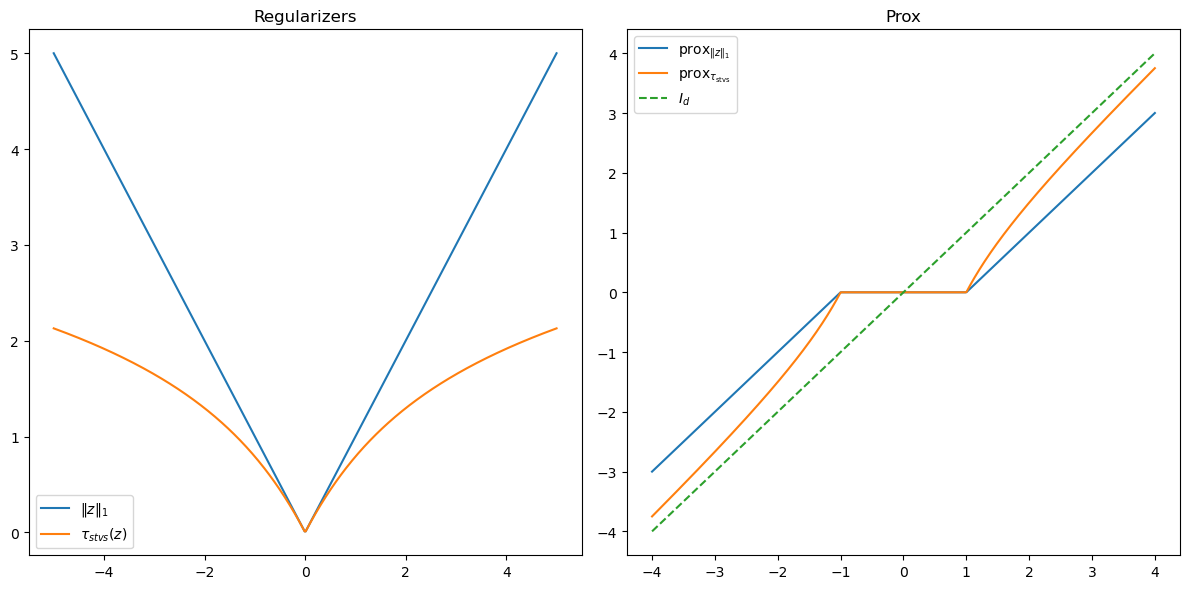

In [3]:
plt.figure(figsize=(12, 6))  

# reg
plt.subplot(1, 2, 1)  
z = jnp.linspace(-5, 5, 500).reshape((-1, 1))
a = jnp.sum(jnp.abs(z), axis=1)
b = jnp.sum((sigma(z, 1) + 0.5 - 0.5 * jnp.exp(-2 * sigma(z, 1))), axis=1)
plt.plot(z, a, label=r'$\|z\|_1$')
plt.plot(z, b, label=r'$\tau_{stvs}(z)$')
plt.title("Regularizers")
plt.legend()

# prox
plt.subplot(1, 2, 2)  
z = jnp.linspace(-4, 4, 500)
a = jnp.where((1 - 1/jnp.abs(z)) > 0, (1 - 1/jnp.abs(z)), 0) * z
b = jnp.where((1 - 1**2 / (jnp.abs(z)**2)) > 0, (1 - 1**2 / (jnp.abs(z)**2)), 0) * z
c = z
plt.plot(z, a, label=r'$\mathrm{prox}_{\|z\|_1}$')
plt.plot(z, b, label=r'$\mathrm{prox}_{\tau_{\mathrm{stvs}}}$')
plt.plot(z,c, label=r'$I_d$',linestyle='dashed')
plt.title("Prox")
plt.legend()

plt.tight_layout()
plt.show()


The STVS regularizer, although non-convex, features a well-defined proximal operator that generally shrinks values to a lesser extent compared to the conventional soft-thresholding operator. 

In contrast, the proximal operator for the $\ell_1$ norm, which implements the classic soft-thresholding approach, actively reduces the magnitude of coefficients. This reduction shifts coefficients towards zero, effectively enhancing sparsity by nullifying smaller values and reducing larger ones by a constant offset.

## Experiments

We delve into two synthetic scenarios where the sparsity pattern of a ground truth transport is either consistently uniform across $x$ or distributed across two distinct regions.

### Constant sparsity-pattern

Here $$\mu = \mathcal{U}_{[0,1]^d}$$
For an integer $s < d$, we set $\nu = T_s^* \# \mu$, where the map $T_s^*$ acts on coordinates independently with the formula $T_s^*(x) = [\exp(x_1), . . . , \exp(x_s), x_{s+1}, . . . , x_d]$ (it only changes the first s coordinates of the vector, and corresponds to a sparse displacement when $s \ll d$).

For this synthetic example, the sparsity pattern is fixed across samples.

We generate n = 1.000 *i.i.d.* samples $x^i$ from $\mu$, and $y^j$ from $\nu$ independently; the samples $y^j$ are obtained by first generating fresh i.i.d. samples $\tilde{x}^j$ from $\mu$ and then pushing them $y^j := T_s^* (\tilde{x}^j)$.


In [4]:
s = 5
def sample_mu(n ,d, key) :
    return jnp.asarray(jax.random.uniform(key, (n,d))) #returns the whole sampled data
def compute_transport(x,s) : #takes a matrix as input
    return jnp.concatenate(( jnp.exp(x[:,:s]), x[:,s:]),-1)

def sample_data(n,d):
    #Sample xi :
    rng = jax.random.PRNGKey(0)
    rng1, rng2 = jax.random.split(rng)
    x = sample_mu(n,d ,rng1)
    t_star = compute_transport(x,s)
    #Sample yi
    x_tilde = sample_mu(n,d ,rng2)
    y = compute_transport(x_tilde,s)
    return x, x_tilde, y, t_star

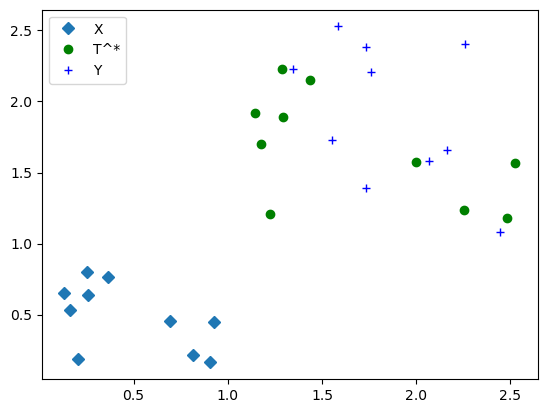

In [5]:
X, X_tilde, Y, T_star = sample_data(10,8)

plt.plot(X[:, 0], X[:, 1], 'D', label='X')  
plt.plot(T_star[:, 0], T_star[:, 1], 'go', label=r'T^*')  
plt.plot(Y[:, 0], Y[:, 1], 'b+', label='Y')  
plt.legend()
plt.show()

We measure our ability to recover $T_s^*$ from $T_{h, \epsilon}$ using a normalized MSE defined as $$\frac{1}{nd} \sum_{i=1}^n \| T_s^*(x^i) -  T_{h, \epsilon} (x^i) \| ^2$$

We also measure how well our method indentifies the correct support: for each sample, we compute the support error as $\sum_{i = s+1}^d \Delta_i^2 / \sum_{i = 1}^d \Delta_i^2$ with $\Delta$ the displacement $T_{h, \epsilon}(x) - x$.

In [6]:
#Define normalized MSE and support error
def normalized_mse(y, y_pred) :
    return  (1/y.shape[1]) * jnp.mean(jnp.linalg.norm(y-y_pred,axis=1)**2)
def support_error(y_pred,x) :
    delta = y_pred -x
    return jnp.mean(jnp.sum(delta[:,s+1:]**2,axis=1) / (jnp.sum(delta**2,axis=1)))

We methodically vary $d$ across the experiments, holding $s$ and $n$ constant, and investigate two distinct cost functions: $\ell_1$ and STVS, juxtaposing them with the conventional $\ell_2^2$ cost.

In [7]:
result ={}

n =  1000

from tqdm import tqdm
for gamma in  tqdm(jnp.logspace(-2, 2, num=100, base=10)) : 
    for d in [8,20,100]:
        for reg_name in [None,'l1', "stvs"]:
            x, x_tilde, y, t_star = sample_data(n,d)
            cost = RegTICost(reg_name=reg_name, gamma=gamma)
            #epsilon=0.8
            geom = ott.geometry.pointcloud.PointCloud(x, y, cost_fn=cost)
            problem = ott.problems.linear.linear_problem.LinearProblem(geom)
            solver = ott.solvers.linear.sinkhorn.Sinkhorn()
            out = solver(problem)
            t_h_eps = out.to_dual_potentials().transport(x)
            nmse = normalized_mse(t_star , t_h_eps)
            s_error = support_error(t_h_eps, x)
            if reg_name is None :
              reg_name = "none"
            result[str(gamma)+"|"+str(d)+"|"+reg_name] = (nmse, s_error)

100%|██████████| 100/100 [03:59<00:00,  2.39s/it]


In [8]:
gammas = []
ds = []
reg_names = []
nmses = []
s_errors = []

# Parse result dictionary
for k, v in result.items():
    gamma, d, reg_name = k.split('|')
    nmse, s_error = v
    gammas.append(float(gamma))
    ds.append(int(d))
    reg_names.append(reg_name)
    nmses.append(nmse)
    s_errors.append(s_error)

# Create DataFrame
df = pd.DataFrame({
    'Gamma': gammas,
    'D': ds,
    'Reg_Name': reg_names,
    'NMSE': nmses,
    'S_Error': s_errors
})
#df.to_csv("df1.csv")

In [9]:
#df = pd.read_csv("df1.csv")

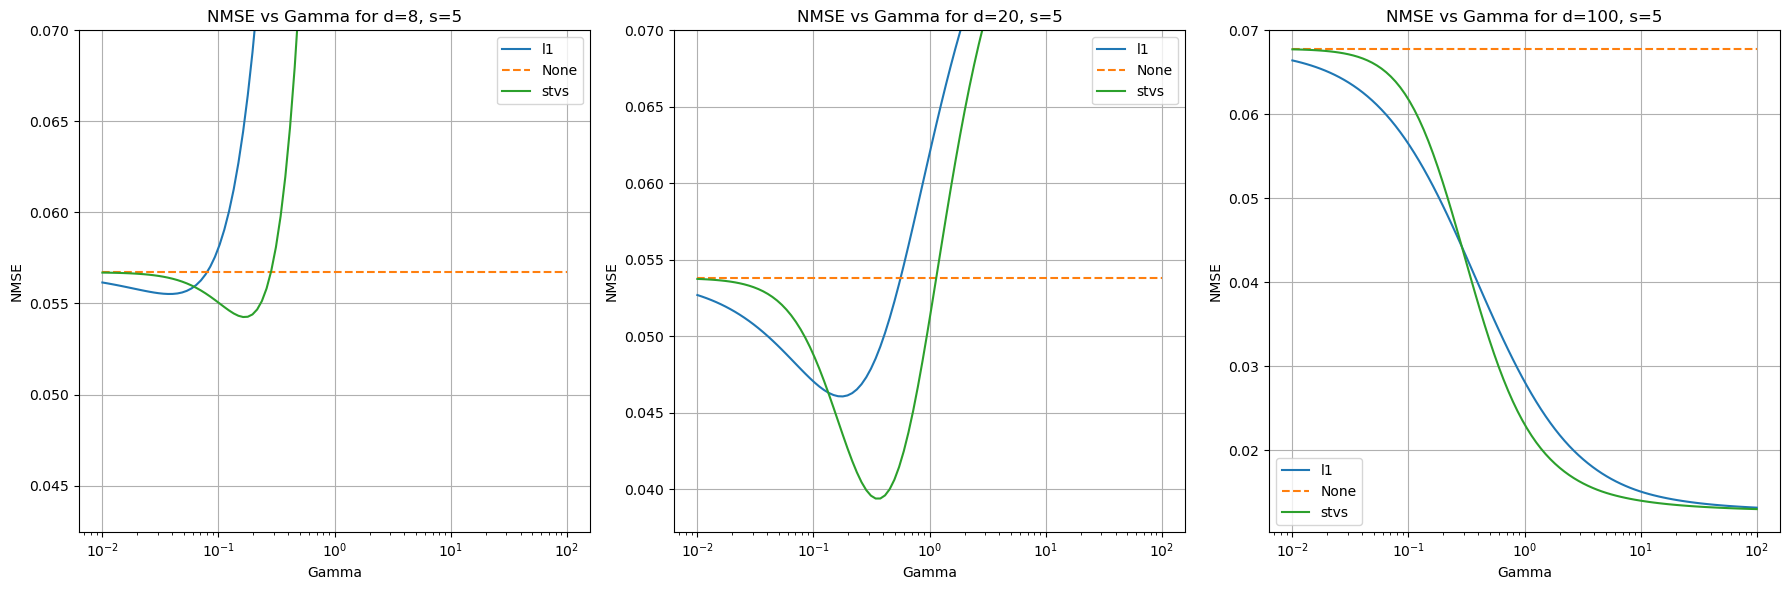

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, (d_value, d_group) in enumerate(df.groupby('D')):
    ax = axs[i]
    for key, grp in d_group.groupby('Reg_Name'):
        if key == "none":
            ax.plot(grp['Gamma'], grp['NMSE'], linestyle='dashed', label='None')
        else:
            ax.plot(grp['Gamma'], grp['NMSE'], label=key)

    ax.set_xlabel('Gamma')
    ax.set_ylabel('NMSE')
    ax.set_title(f'NMSE vs Gamma for d={d_value}, s=5')
    ax.set_xscale('log')
    ax.set_ylim(top=0.07)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

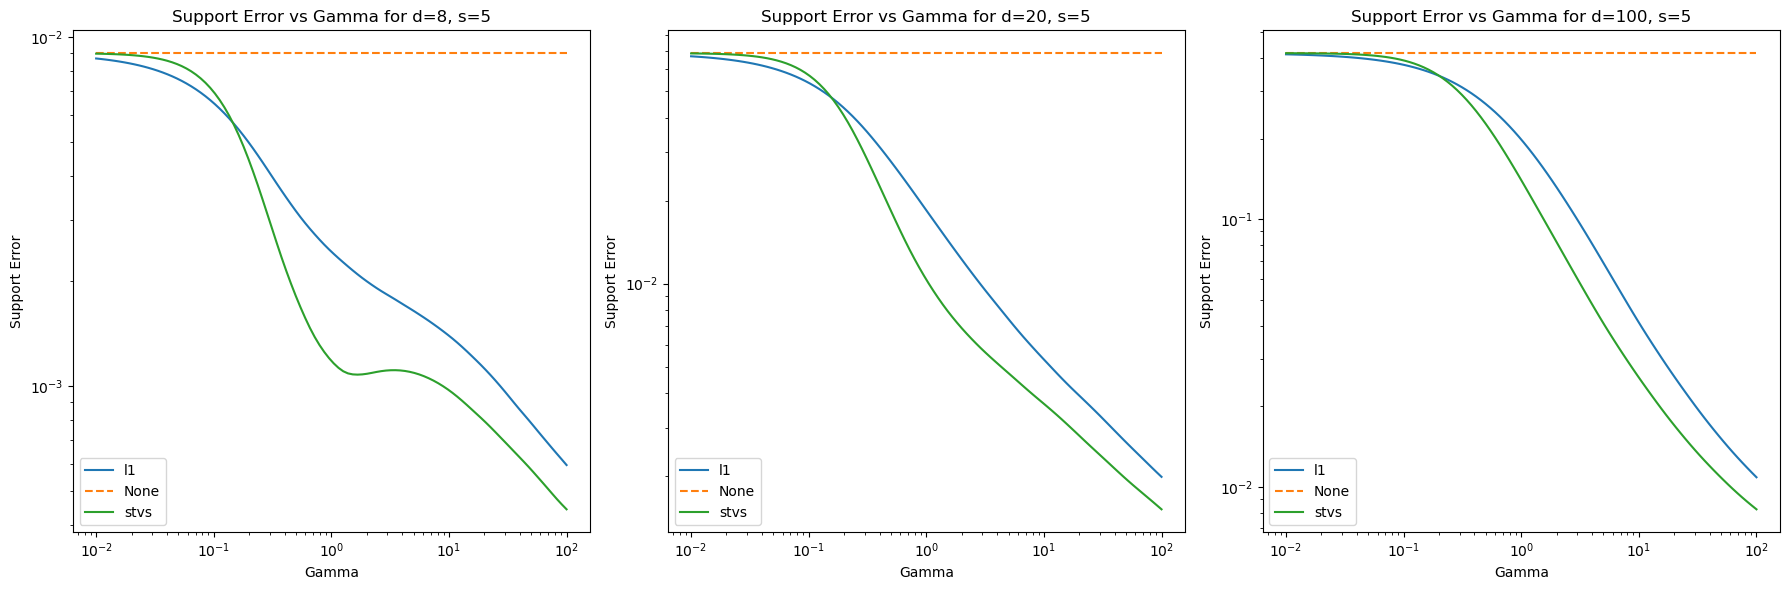

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, (d_value, d_group) in enumerate(df.groupby('D')):
    ax = axs[i]
    for key, grp in d_group.groupby('Reg_Name'):
        if key == "none":
            ax.plot(grp['Gamma'], grp['S_Error'], linestyle='dashed', label='None')
        else:
            ax.plot(grp['Gamma'], grp['S_Error'], label=key)

    ax.set_xlabel('Gamma')
    ax.set_ylabel('Support Error')
    ax.set_title(f'Support Error vs Gamma for d={d_value}, s=5')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

- When $d \approx s$ : the $\ell_2^2$ cost demonstrates good performance, and the proposed costs marginally enhance it for a fixed regularization in terms of MSE.

- When $d > s$ : both costs improve over the $\ell_2^2$ cost, and the optimal regularization for $\ell_1$ and $\tau_{stvs}$ is finite. However, excessive regularization leads to an explosion in MSE.

- When $d \gg s$ : the proposed methods significantly outperform the $\ell_2^2$ cost. The optimal regularization for $\ell_1$ and $\tau_{stvs}$ becomes infinite, even for the MSE.

In terms of support error, any form of regularization outperforms the $\ell_2$ cost, with larger regularization consistently yielding better results, regardless of the value of $d$.

### x-dependent sparsity-pattern

To demonstrate the efficacy of our method in recovering transport maps with adaptive sparsity patterns, contingent on the input $x$, we extend the previous setting as follows :

We compute first the norms of two coordinate groups of $x$ :

$$ n_1 = \sum_{i=1}^s x_i^2 \quad \text{and} \quad n_2 = \sum_{i=s+1}^{2s} x_i^2$$

Second, we displace the coordinate group with the largest norm, for example : 
if $n_1 > n_2$

$$ \text{if} \quad n_1 > n_2, \quad F_s(x) = [\exp(x_1), \dots , \exp(x_s), x_{s+1}, \dots , x_{d} ] $$

$$ \text{if} \quad n_1 \leq n_2, \quad F_s(x) = [x_1, \dots , x_s, \exp(x_{s+1}), \dots , \exp(x_{2s}), x_{2s+1}, \dots , x_{d} ] $$

Thus, the displacement pattern depends on x.

In [18]:
n = 100
s= 2
def F(x,s) :
    n1s = jnp.sum(x[:,:s]**2,axis = 1)
    n2s = jnp.sum(x[:,s:2*s]**2,axis = 1)
    result = []
    for i, (n1,n2) in enumerate(zip(n1s, n2s)):
        if n1> n2 :
            result.append(jnp.concatenate(( jnp.exp(x[i,:s]), x[i,s:]),-1))

        else :
            result.append(jnp.concatenate(( x[i,:s], jnp.exp(x[i,s:2*s]), x[i,2*s:]),-1))
    return jnp.stack(result)
    
def sample_data(d):
    #Sample xi :
    rng = jax.random.PRNGKey(0)
    rng1, rng2 = jax.random.split(rng)
    x = sample_mu(n,d ,rng1)
    t_star = F(x,s)
    #Sample yi
    x_tilde = sample_mu(n,d ,rng2)
    y = F(x_tilde,s)
    return x, x_tilde, y, t_star

We assess our capability to reconstruct $T_s^*$ from $T_{h, \epsilon}$ using normalized Mean Squared Error (MSE) and support error metrics, as described earlier.

We systematically vary the dimensionality, $d$, while keeping $n$ and $s$ constant across the experiments, testing two distinct cost functions: $\ell_1$ and STVS. These are then compared against the traditional $\ell_2^2$ cost.

In [19]:
result = {}
for d in tqdm(jnp.logspace(0.7, 3, num=10, base=10)):
    d = int(d)
    for reg_name in ['l1', "stvs", None]:
        for gamma in  jnp.linspace(1e-2,1e1, 10) : #We'll keep the value of lowest NMSE
            x, x_tilde, y, t_star = sample_data(d)
            cost = RegTICost(reg_name=reg_name, gamma=gamma)
            #epsilon=0.1
            geom = ott.geometry.pointcloud.PointCloud(x, y, cost_fn=cost)
            problem = ott.problems.linear.linear_problem.LinearProblem(geom)
            solver = ott.solvers.linear.sinkhorn.Sinkhorn()
            out = solver(problem)
            t_h_eps = out.to_dual_potentials().transport(x)
            nmse = normalized_mse(t_star , t_h_eps)
            if reg_name is None :
              reg_name = "none"
            if str(d)+"|"+reg_name not in result.keys() or result[str(d)+"|"+reg_name]>nmse:
                result[str(d)+"|"+reg_name] = nmse
            if reg_name == "none" :
              reg_name = None

100%|██████████| 10/10 [01:33<00:00,  9.34s/it]


In [20]:
#process the data and plot
ds = []
reg_names = []
nmses = []

# Parse result dictionary
for k, v in result.items():
    d, reg_name = k.split('|')
    nmse = v
    ds.append(int(d))
    reg_names.append(reg_name)
    nmses.append(nmse)

# Create DataFrame
df2 = pd.DataFrame({
    'D': ds,
    'Reg_Name': reg_names,
    'NMSE': nmses,
})
#df2.to_csv("df2.csv")

In [ ]:
#df2 = pd.read_csv("df2.csv")

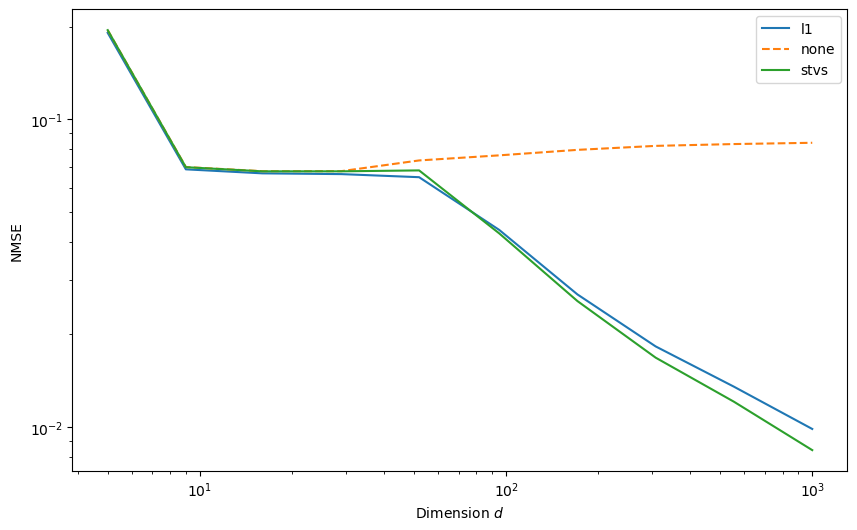

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

for reg_name, reg_group in df2.groupby('Reg_Name'):
    if reg_name != "none":
        ax.plot(reg_group['D'], reg_group['NMSE'], label=reg_name)
    else:
        ax.plot(reg_group['D'], reg_group['NMSE'], linestyle='dashed', label="none")

ax.set_xlabel(r'Dimension $d$')
ax.set_ylabel('NMSE')
ax.set_xscale('log')  
ax.set_yscale('log')  
ax.legend()
plt.show()

As anticipated, we notice a significantly improved scaling behavior for our costs compared to the standard $\ell_2^2$ cost. This observation suggests that sparsity-inducing costs effectively alleviate the curse of dimensionality.

## Conclusion

In this tutorial, through the adoption of elastic-type costs, which blend an $\ell_2$ term with a sparsifying component, the resulting maps demonstrate sparsity, selectively affecting specific coordinates. 